# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. Есть исторические данные: технические характеристики, комплектации и цены автомобилей. Нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

## Подготовка данных

In [1]:
pip install lightgbm

     ---------------------------------------- 0.0/1.3 MB ? eta -:--:--
     ---------------------------------------- 0.0/1.3 MB ? eta -:--:--
      --------------------------------------- 0.0/1.3 MB 435.7 kB/s eta 0:00:03
     -- ------------------------------------- 0.1/1.3 MB 491.5 kB/s eta 0:00:03
     -- ------------------------------------- 0.1/1.3 MB 581.0 kB/s eta 0:00:03
     ---- ----------------------------------- 0.2/1.3 MB 654.6 kB/s eta 0:00:02
     ---- ----------------------------------- 0.2/1.3 MB 614.4 kB/s eta 0:00:02
     ------ --------------------------------- 0.2/1.3 MB 765.3 kB/s eta 0:00:02
     ------- -------------------------------- 0.3/1.3 MB 714.4 kB/s eta 0:00:02
     -------- ------------------------------- 0.3/1.3 MB 737.3 kB/s eta 0:00:02
     --------- ------------------------------ 0.3/1.3 MB 731.4 kB/s eta 0:00:02
     ---------- ----------------------------- 0.4/1.3 MB 768.6 kB/s eta 0:00:02
     ----------- ---------------------------- 0.4/1.3 MB 7

In [2]:
pip install catboost

Note: you may need to restart the kernel to use updated packages.


In [3]:
import pandas as pd
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
import lightgbm as lgb
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
from catboost import CatBoostRegressor, Pool
from sklearn.preprocessing import OrdinalEncoder

In [4]:
data = pd.read_csv('https://code.s3.yandex.net/datasets/autos.csv')

Рассмотрим данные

In [5]:
data.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [6]:
data.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


Очевидно, "NumberOfPictures" совершенно не информативный столбец. Есть 0 в цене, мощности и месяце регистрации - скорее всего, аномалии. Есть странные годы регистрации, в 1000 году вряд ли уже производили машины, доступные для продажи сейчас. Также мощность в л.с. для спортивных машин достигает предела в 1500-1700 л.с., для обычных - 200-300, не больше, значение в 20000 явно аномально.

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

Присутствует много пропусков, особенно в столбце "Repaired"

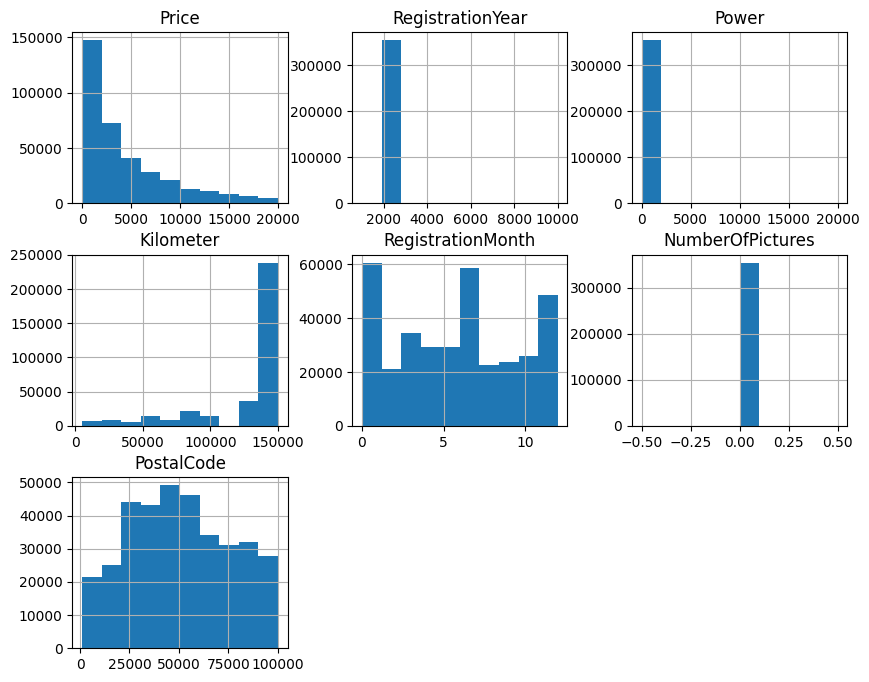

In [8]:
data.hist(figsize = (10, 8));

In [9]:
data_new = data.copy()

Проверим наличие дубликатов и уберем их, если нужно

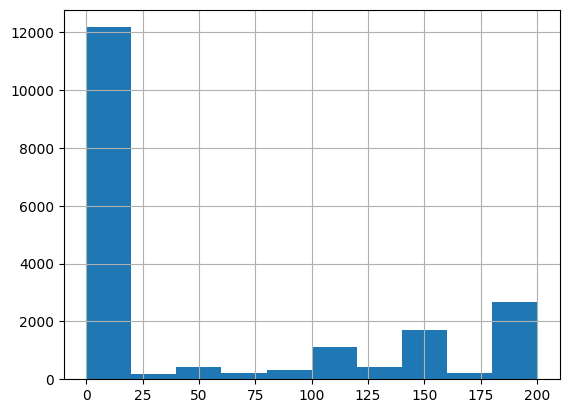

In [10]:
data_new['Price'].hist(range=(0,200));

Почти 4 % машин имеют цену менее 100 евро, что даже при нынешнем курсе меньше 10000 рублей, стоит убрать такие данные, но если отрезать больше данных, можно привести к ошибкам в модели

In [11]:
data_new.query('Price < 100')['Price'].count()/ data_new['Price'].count()*100

3.757100649323163

In [12]:
data_new = data_new.loc[data_new['Price'] > 25]

Минимальная возможная мощность машины, исходя из поиска - около 20 л.с., для довольно редко встречающихся моделей. Мозность спортивных моделей - около 1500 л.с., большинство данных о мозности машин, не входящих в эти рамки - аномальные. Посмотрим, какаяя это часть от датасета

In [13]:
data_new.query('Power < 20')['Power'].count()/data_new['Power'].count()*100

10.5370849970477

Данные о машинах с мозностью до 20 л.с. занимают 10 процентов от датасета, их не стоит убирать, это повлияет на модель. Я бы предположила, что это данные о мопедах, но нет, и это ставит меня в тупик в данном моменте.

In [14]:
data_new.query('Power < 20')['VehicleType'].unique()

array([nan, 'small', 'sedan', 'wagon', 'coupe', 'bus', 'convertible',
       'other', 'suv'], dtype=object)

In [15]:
data_new.query('Power > 1500 ')['Power'].count()/data_new['Power'].count()*100

0.054661420729247664

А данные о высоких мощностях можно убрать

Ограничим возможную мощность примерным максимальным возможным значением

In [16]:
data_new = data_new.loc[data_new['Power'] <= 1500]

Оставим наиболее реальные годы регистрации: первая машина появлась в 1885, а сейчас 2023 год, так что год регистрации машины вне этих рамок нереален. Похожие устройством на современные автомобили появились к 1-й мировой (~1930 г.), их могли бы уже продавать в качестве коллекционныъ. Тогда посмотрим, какую долю от данных будт занимать данные до 1930 года и после 2023

In [17]:
data_new.query('RegistrationYear < 1930 or RegistrationYear > 2023')['RegistrationYear'].count()/data_new['RegistrationYear'].count()*100

0.052059113415750514

Около 0.1 %, стоит убрать аномальные данные

In [18]:
data_new = data_new.loc[(data_new['RegistrationYear'] > 1929) & (data_new['RegistrationYear'] < 2024)] 

На категориальные столбцы 'Repaired' и 'Model' поставим заглушку 'Unknown' для пропусков

In [19]:
data_new['Repaired'] = data_new['Repaired'].fillna('Unknown')

In [20]:
data_new['Model'] = data_new['Model'].fillna('Unknown')

Пропуски в 'FuelType', 'Gearbox' и 'VehicleType' заполним наиболее частым значением для данных, сгрупированных по модели машины и бренду

In [21]:
data_new['FuelType'] = data_new['FuelType'].fillna(data_new.groupby(['Model', 'Brand'])['FuelType'].transform(lambda x: x.value_counts().idxmax()))

In [22]:
data_new['Gearbox'] = data_new['Gearbox'].fillna(data_new.groupby(['Model', 'Brand'])['Gearbox'].transform(lambda x: x.value_counts().idxmax()))

In [23]:
data_new['VehicleType'] = data_new['VehicleType'].fillna(data_new.groupby(['Model', 'Brand'])['VehicleType'].transform(lambda x: x.value_counts().idxmax()))

Данные выглядят лучше, RegistrationMonth не исправляла, так как это неинформативный признак

In [24]:
data_new.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,341741.000000,341741.000000,341741.000000,341741.000000,341741.000000,341741.0,341741.000000
mean,4576.278635,2003.210932,108.145280,128487.758273,5.792000,0.0,50700.511010
std,4515.012639,7.242333,66.167492,37271.833953,3.692103,0.0,25742.844841
min,26.000000,1930.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1200.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30453.000000
50%,2900.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49525.000000
75%,6500.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71254.000000
max,20000.000000,2019.000000,1500.000000,150000.000000,12.000000,0.0,99998.000000


Уберем столбцы, которые кажутся мне неинформативными для модели

In [25]:
non_informative = ['NumberOfPictures', 'PostalCode', 'DateCrawled', 'DateCreated', 'LastSeen', 'RegistrationMonth']

In [26]:
data_new = data_new.drop(non_informative, axis=1)

In [27]:
data_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 341741 entries, 0 to 354368
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Price             341741 non-null  int64 
 1   VehicleType       341741 non-null  object
 2   RegistrationYear  341741 non-null  int64 
 3   Gearbox           341741 non-null  object
 4   Power             341741 non-null  int64 
 5   Model             341741 non-null  object
 6   Kilometer         341741 non-null  int64 
 7   FuelType          341741 non-null  object
 8   Brand             341741 non-null  object
 9   Repaired          341741 non-null  object
dtypes: int64(4), object(6)
memory usage: 28.7+ MB


Посмотрим на наличие корреляций между численными признаками

In [28]:
data_new.duplicated().sum()

46566

In [29]:
data_new = data_new.drop_duplicates(keep='first')

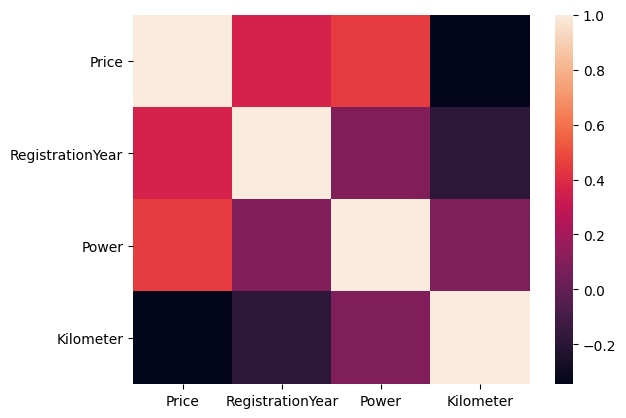

In [30]:
sns.heatmap(data_new.corr());

На стоимость машины прямопропорционально влияют год регистрации машины и ее мощность, обратно пропроционально проеханнй километраж

Итог: 
- Данные изучены
- Удалены аномальные численные значения для цены, мощности машин, а также года регистрации, количество данных уменьшилось менее, чем на 5 проецнтов
- Заполнены пропуски в данных, где это возможно, либо поставлены заглушки
- Удалены неинформативные для модели признаки
- Рассмотрены корреляции в оставшихся признаках

## Обучение моделей

Выделим категориальные признаки, присвоим им категориальный тип

In [31]:
rand = 12345

In [32]:
cat_features = ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'Repaired']
for item in cat_features:
    data_new[item] = data_new[item].astype("category")

Разделим данные на обучающую и тестовую выборки

In [33]:
data_train, data_test = train_test_split(data_new, test_size=0.2, random_state=rand)

In [34]:
features = data_train.drop('Price', axis=1)
target = data_train['Price']

In [35]:
features_test = data_test.drop('Price', axis=1)
target_test = data_test['Price']

In [36]:
ordinal_encoder = OrdinalEncoder(dtype=int, handle_unknown='use_encoded_value', unknown_value=-1)
features[cat_features] = ordinal_encoder.fit_transform(features[cat_features])
features_test[cat_features] = ordinal_encoder.transform(features_test[cat_features])
features_test.head()

,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
40236,6,2006,0,224,222,150000,2,38,1
72842,4,1984,0,147,167,150000,6,10,2
286173,1,1997,1,75,43,150000,6,24,1
292335,1,2000,0,54,107,150000,6,32,0
298799,5,2003,1,80,103,150000,6,10,1


Подберем гиперпараметры для разных моделей: LGBMRegressor, RandomForestRegressor и CatBoostRegressor

In [37]:
%%time
lg = lgb.LGBMRegressor(num_leaves= 31,learning_rate=0.01, random_state=rand)

param_grid = {'n_estimators': [10,50,100,200,250],
              'max_depth': [1,5,10,15,20]
   
}

cv =KFold(random_state=1, n_splits=7, shuffle=True)
gbm = GridSearchCV(lg, param_grid, cv=cv, scoring='neg_root_mean_squared_error', verbose=5)

gbm.fit(features, target, categorical_feature=cat_features)

print('Лучшие параметры:' +str(gbm.best_params_))
print('Лучшее значение RMSE:' +str(-gbm.best_score_))

Fitting 7 folds for each of 25 candidates, totalling 175 fits
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004010 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 657
[LightGBM] [Info] Number of data points in the train set: 202405, number of used features: 9
[LightGBM] [Info] Start training from score 4675.522981
[CV 1/7] END ...................max_depth=1, n_estimators=10; total time=   0.2s
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002423 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 658
[LightGBM] [Info] Number of data points in the train set: 202405, number of used features: 9
[LightGBM] [Info] Start training from score 4666.023517
[CV 2/7] END ...................max_depth

In [38]:
%%time
rf = RandomForestRegressor(random_state=rand)
grid_space={'max_depth':[3,5, 10],
            'n_estimators':[10,50]
           }

cv =KFold(random_state=1, n_splits=7, shuffle=True)
gbm_rf = GridSearchCV(rf,param_grid=grid_space,cv=cv,scoring='neg_root_mean_squared_error', verbose=5)

gbm_rf.fit(features, target)

print('Лучшие параметры:'+str(gbm_rf.best_params_))
print('Лучшее значение RMSE:' +str(-gbm_rf.best_score_))

Fitting 7 folds for each of 6 candidates, totalling 42 fits
[CV 1/7] END ...................max_depth=3, n_estimators=10; total time=   1.0s
[CV 2/7] END ...................max_depth=3, n_estimators=10; total time=   0.8s
[CV 3/7] END ...................max_depth=3, n_estimators=10; total time=   0.8s
[CV 4/7] END ...................max_depth=3, n_estimators=10; total time=   0.8s
[CV 5/7] END ...................max_depth=3, n_estimators=10; total time=   0.8s
[CV 6/7] END ...................max_depth=3, n_estimators=10; total time=   0.8s
[CV 7/7] END ...................max_depth=3, n_estimators=10; total time=   0.9s
[CV 1/7] END ...................max_depth=3, n_estimators=50; total time=   4.6s
[CV 2/7] END ...................max_depth=3, n_estimators=50; total time=   4.0s
[CV 3/7] END ...................max_depth=3, n_estimators=50; total time=   3.9s
[CV 4/7] END ...................max_depth=3, n_estimators=50; total time=   4.2s
[CV 5/7] END ...................max_depth=3, n_es

In [39]:
%%time
cb = CatBoostRegressor(random_state=rand)

grid = {'learning_rate': [0.1, 0.5],
        'depth': [5, 10]}

cv =KFold(random_state=rand, n_splits=7, shuffle=True)
gbm_cb = GridSearchCV(cb, grid, cv=cv, scoring='neg_root_mean_squared_error', verbose=5)
gbm_cb.fit(features, target, cat_features=cat_features)

print('Лучшие параметры:' +str(gbm_cb.best_params_))
print('Лучшее значение RMSE:' +str(-gbm_cb.best_score_))

Fitting 7 folds for each of 4 candidates, totalling 28 fits
0:	learn: 4302.7798964	total: 297ms	remaining: 4m 56s
1:	learn: 4068.2662087	total: 389ms	remaining: 3m 13s
2:	learn: 3862.8365041	total: 499ms	remaining: 2m 45s
3:	learn: 3663.1289672	total: 611ms	remaining: 2m 32s
4:	learn: 3499.7098038	total: 723ms	remaining: 2m 23s
5:	learn: 3360.4488227	total: 858ms	remaining: 2m 22s
6:	learn: 3219.9273145	total: 983ms	remaining: 2m 19s
7:	learn: 3109.6867040	total: 1.14s	remaining: 2m 21s
8:	learn: 3002.1051342	total: 1.25s	remaining: 2m 17s
9:	learn: 2912.0339779	total: 1.35s	remaining: 2m 14s
10:	learn: 2831.1859089	total: 1.48s	remaining: 2m 13s
11:	learn: 2758.0858198	total: 1.6s	remaining: 2m 11s
12:	learn: 2687.3971841	total: 1.7s	remaining: 2m 8s
13:	learn: 2623.7937964	total: 1.78s	remaining: 2m 5s
14:	learn: 2568.1648152	total: 1.91s	remaining: 2m 5s
15:	learn: 2515.2739678	total: 2.02s	remaining: 2m 4s
16:	learn: 2471.1563780	total: 2.1s	remaining: 2m 1s
17:	learn: 2428.9928945

При подобранных гиперпараметрах лучше всего точность у CatBoostRegressor, хуже всего у RandomForestRegressor

Итог: 
- Подобраны гиперпараметры для трех разных регрессионных моделей: LGBMRegressor, RandomForestRegressor и CatBoostRegressor
- Скорость поддбора гиперпараметров для LGBMRegressor и RandomForestRegressor близка, в то время как для CatBoost сильно дольше
- Точность предказания, однако, лучше у CatBoost

## Анализ моделей

Проверим среднюю скорость обучения и предсказания для моделей

In [40]:
print("RandomForestRegressor: Время обучения:", np.mean(gbm_rf.cv_results_['mean_fit_time']),
      ", время предсказания", np.mean(gbm_rf.cv_results_['mean_score_time']))
print("LGBMRegressor: Время обучения:", np.mean(gbm.cv_results_['mean_fit_time']),
      ", время предсказания", np.mean(gbm.cv_results_['mean_score_time']))
print("CatBoostRegressor: Время обучения:", np.mean(gbm_cb.cv_results_['mean_fit_time']),
      ", время предсказания", np.mean(gbm_cb.cv_results_['mean_score_time']))

RandomForestRegressor: Время обучения: 4.473078926404317 , время предсказания 0.04873991012573242
LGBMRegressor: Время обучения: 0.9452338177817208 , время предсказания 0.07496617180960519
CatBoostRegressor: Время обучения: 1563.3498163308418 , время предсказания 0.2611078875405448


Быстрее всего обучается LGBMRegressor, медленнее всего CatBoostRegressor с большим разрывом, примерно в 500 раз дольше, чем LGBMRegressor. RandomForestRegressor обучается примерно в 5 раз дольше, чем LGBMRegressor

Быстрее всего предсказывает также LGBMRegressor, но примерно наравне по скорости с RandomForestRegressor и примерно в два раза быстрее, чем CatBoostRegressor

In [41]:
predictions_lg = gbm.best_estimator_.predict(features_test)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


In [42]:
print('RMSE для LGBMRegressor', (mean_squared_error(target_test, predictions_lg))**(1/2))

RMSE для LGBMRegressor 1967.74131855489


Итог:
- Определены скорости обучения и предсказания для трех моделей: LGBMRegressor, RandomForestRegressor и CatBoostRegressor
- Скорость обучения и предсказания выше всего у LGBMRegressor
- Наименьшая ошибка у CatBoostRegressor, RMSE для LGBMRegressor на 20% больше, чем для CatBoostRegressor

Общий итог:
- Проанализированы и подготовлены данные: заполнены пропуски, убраны аномалии, а также убраны неинформативные признаки
- Подобраны гиперпараметры для трех разных регрессионных моделей: LGBMRegressor, RandomForestRegressor и CatBoostRegressor. 
- Модели обучены, проанализирована скорость их работы: быстрее всего обучается и предсказывает LGBMRegressor
- Проанализирована точность предсказания моделей: точнее всего предсказывает CatBoostRegressor
- Для заказчика наиболее подойдет LGBMRegressor, так как он выигрывает по двум пунктам из трех: наиболее быстро предсказывает и обучается. CatBoostRegressor выигрывает по точности предсказания, но обучается слишком медленно, что создает больший перевес в сторону LGBMRegressor.